# Import libraries and data 

In [1]:
# PICKLING
import pickle

# DF'S, MATHS AND PLOTTING
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# MODELLING
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
sampled_families = pd.read_pickle('../Data/sampled_families_pickle')
sampled_families.reset_index(drop = True, inplace = True)

In [3]:
sampled_families.head()

,image,species,individual_id,family,genus,img_array
0,6ac0440827a1c4.jpg,melon_headed_whale,926b0ae3be20,Delphinidae,Peponocephala,"[[[255, 116, 0], [255, 116, 0], [255, 124, 0],..."
1,5c62aa0470b486.jpg,bottlenose_dolphin,0af729ecbdf7,Delphinidae,Tursiops,"[[[130, 255, 126], [146, 255, 110], [154, 255,..."
2,6decfec40b4662.jpg,bottlenose_dolphin,b9b86ad7a094,Delphinidae,Tursiops,"[[[70, 255, 186], [66, 255, 190], [62, 255, 19..."
3,9fcd68d085137a.jpg,bottlenose_dolphin,e736e034ad0c,Delphinidae,Tursiops,"[[[70, 255, 186], [66, 255, 190], [46, 255, 21..."
4,89304ac4df7277.jpg,pantropic_spotted_dolphin,098ba04354fb,Delphinidae,Stenella,"[[[255, 52, 0], [255, 68, 0], [255, 56, 0], [2..."


# Useful functions 

In [ ]:
def plot_learning_curves(model_history, validation = False):
    
    """
    Plot accuracy and loss through training epochs, with or without a validation set
    """
    
    df = pd.DataFrame(model_history.history)
    df['epoch'] = range(len(df))

    fig, ax = plt.subplots(1, 2, figsize = (10,4))
    plt.suptitle('Learning curves')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')

    if validation == False:
        sns.lineplot(data = df['accuracy'], ax = ax[0])
        sns.lineplot(data = df['loss'], ax = ax[1])
    else:
        sns.lineplot(data = df[['accuracy', 'val_accuracy']], ax = ax[0])
        ax[0].legend(['training', 'validation'])
        
        sns.lineplot(data = df[['loss', 'val_loss']], ax = ax[1])
        ax[1].legend(['training', 'validation'])
        
    return

def find_family(pred, enc):
    
    """
    Decode a family using a specific encoder instantiation from a list of probabilities. 
    The highest probability will be the assigned family.
    """
    
    key = list(pred).index(pred.max())
    fam = enc[key]
    
    return fam

def decode(predictions, enc):
    
    """Decode a list of families from a specific encoder instatiation"""
    
    fams = []
    for row in predictions:
        fams.append(find_family(row, enc))
    
    return fams

def find_max(pred):
    """
    Find max probability from preditions
    """
    int_pred = []
    for row in pred:
        int_pred.append(list(row).index(row.max()))
    return int_pred

def full_classification_report(X_tr, X_te, y_tr, y_te, model):
    
    """
    Produce trian and test evaluation metrics of a model
    """
    
    # Train
    y_pred_train = model.predict(X_tr)
    print('###################### TRAIN SET ######################\n\n', 
          classification_report(y_tr, find_max(y_pred_train)), '\n\n')

    # Test
    y_pred = model.predict(X_te)
    print('###################### TEST SET ######################\n\n', 
          classification_report(y_te, find_max(y_pred)))
    
    return

def model_evaluate(model, history, X_tr, X_te, y_tr, y_te, val = False):
    
    """
    Plot learning curves and the full classification report of a model given training, test and optionally validation data
    """
    
    plot_learning_curves(history, validation = val)
    full_classification_report(X_tr, X_te, y_tr, y_te, model)
    
    return

# Check data 

In [8]:
sampled_families.isnull().sum()
# no nulls

image            0
species          0
individual_id    0
family           0
genus            0
img_array        0
dtype: int64

In [9]:
features = sampled_families.columns
sampled_families[sampled_families[features[:-1]].duplicated()]
# no duplicates

,image,species,individual_id,family,genus,img_array


In [10]:
sampled_families.dtypes

image            object
species          object
individual_id    object
family           object
genus            object
img_array        object
dtype: object

# Modelling
## Split and feature engineer

In [11]:
sampled_families['family'].value_counts(normalize=True)
# no stratification necessary

Delphinidae        0.2
Balaenopteridae    0.2
Monodontidae       0.2
Balaenidae         0.2
Ziphiidae          0.2
Name: family, dtype: float64

In [7]:
X = []
for elem in sampled_families['img_array']:
    X.append(elem)
    
X = np.array(X, dtype = 'float')
y = sampled_families['family'].copy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
print(X_train.shape, X_test.shape) # check shape of image arrays
print(y_train.shape, y_test.shape)

# 356x356 in pixels with 3 channels (RGB)

(1364, 356, 356, 3) (341, 356, 356, 3)
(1364,) (341,)


In [9]:
lab_enc = LabelEncoder().fit(y_train)
y_train = lab_enc.transform(y_train)
y_test = lab_enc.transform(y_test)
lab_enc_map = {i: l for i, l in enumerate(lab_enc.classes_)}

In [10]:
# normalise image arrays
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

## Artificial Neural Network 

In [17]:
ann = models.Sequential([
        layers.Flatten(input_shape=(356,356,3)),
        layers.Dense(300, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(5, activation='softmax')    
    ])

ann.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann_hist = ann.fit(X_train_norm, y_train, epochs=10)

Epoch 1/10
43/43 [==============================] - 20s 335ms/step - loss: 18.1823 - accuracy: 0.2104
Epoch 2/10
43/43 [==============================] - 15s 350ms/step - loss: 1.6309 - accuracy: 0.2170
Epoch 3/10
43/43 [==============================] - 16s 360ms/step - loss: 1.6093 - accuracy: 0.2075
Epoch 4/10
43/43 [==============================] - 15s 358ms/step - loss: 1.6092 - accuracy: 0.2075
Epoch 5/10
43/43 [==============================] - 15s 342ms/step - loss: 1.6092 - accuracy: 0.2075
Epoch 6/10
43/43 [==============================] - 15s 342ms/step - loss: 1.6092 - accuracy: 0.2075
Epoch 7/10
43/43 [==============================] - 15s 340ms/step - loss: 1.6092 - accuracy: 0.2075
Epoch 8/10
43/43 [==============================] - 15s 339ms/step - loss: 1.6092 - accuracy: 0.2075
Epoch 9/10
43/43 [==============================] - 15s 340ms/step - loss: 1.6092 - accuracy: 0.2075
Epoch 10/10
43/43 [==============================] - 15s 338ms/step - loss: 1.6093 - accur

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###################### TRAIN SET ######################

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       260
           1       0.00      0.00      0.00       270
           2       0.21      1.00      0.34       283
           3       0.00      0.00      0.00       273
           4       0.00      0.00      0.00       278

    accuracy                           0.21      1364
   macro avg       0.04      0.20      0.07      1364
weighted avg       0.04      0.21      0.07      1364
 




C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###################### TEST SET ######################

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.00      0.00      0.00        71
           2       0.17      1.00      0.29        58
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00        63

    accuracy                           0.17       341
   macro avg       0.03      0.20      0.06       341
weighted avg       0.03      0.17      0.05       341



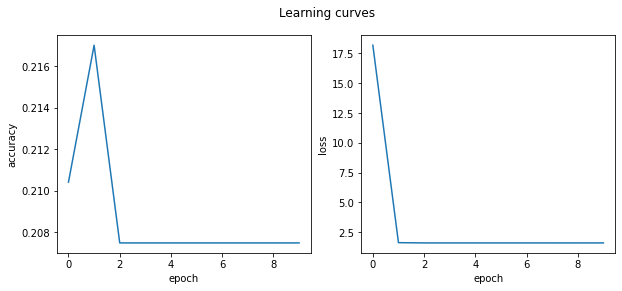

In [18]:
model_evaluate(ann, ann_hist, X_train, X_test, y_train, y_test)

Only recognising observations as class 2. 

## Convolutional Neural Network 

In [11]:
cnn = models.Sequential([
    layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(356, 356, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_hist = cnn.fit(X_train_norm, y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
35/35 [==============================] - 58s 2s/step - loss: 3.0017 - accuracy: 0.3474 - val_loss: 1.4828 - val_accuracy: 0.3883
Epoch 2/10
35/35 [==============================] - 53s 2s/step - loss: 1.1478 - accuracy: 0.5518 - val_loss: 1.3079 - val_accuracy: 0.5495
Epoch 3/10
35/35 [==============================] - 52s 2s/step - loss: 0.9975 - accuracy: 0.6370 - val_loss: 1.1768 - val_accuracy: 0.6154
Epoch 4/10
35/35 [==============================] - 72s 2s/step - loss: 0.8272 - accuracy: 0.6874 - val_loss: 1.0323 - val_accuracy: 0.6593
Epoch 5/10
35/35 [==============================] - 66s 2s/step - loss: 0.7469 - accuracy: 0.7379 - val_loss: 1.0184 - val_accuracy: 0.6374
Epoch 6/10
35/35 [==============================] - 64s 2s/step - loss: 0.6878 - accuracy: 0.7544 - val_loss: 1.0765 - val_accuracy: 0.6007
Epoch 7/10
35/35 [==============================] - 61s 2s/step - loss: 0.5049 - accuracy: 0.8396 - val_loss: 0.9774 - val_accuracy: 0.6484
Epoch 8/10
35/35 [==

###################### TRAIN SET ######################

               precision    recall  f1-score   support

           0       0.93      0.92      0.93       260
           1       0.85      0.89      0.87       270
           2       0.96      0.88      0.92       283
           3       0.89      0.95      0.92       273
           4       0.91      0.90      0.91       278

    accuracy                           0.91      1364
   macro avg       0.91      0.91      0.91      1364
weighted avg       0.91      0.91      0.91      1364
 


###################### TEST SET ######################

               precision    recall  f1-score   support

           0       0.79      0.74      0.76        81
           1       0.46      0.51      0.48        71
           2       0.58      0.48      0.53        58
           3       0.79      0.78      0.79        68
           4       0.56      0.63      0.59        63

    accuracy                           0.64       341
   macro avg 

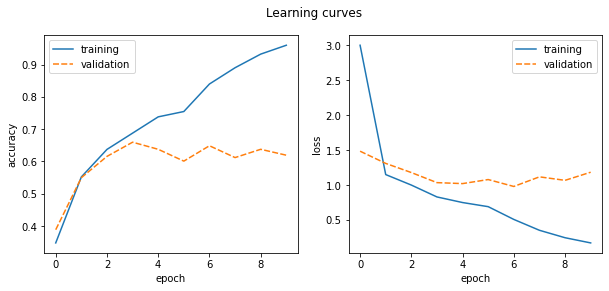

In [12]:
model_evaluate(cnn, cnn_hist, X_train_norm, X_test_norm, y_train, y_test, val = True)

Overfit the training data. Needs more regularisation.